# 0.0 IMPORTS

In [84]:
## 0.1 Helper Functions

import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns


from matplotlib            import pyplot as plt
from IPython.display       import Image
from scipy                 import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from boruta                import BorutaPy

## 0.1 Helper Functions

In [3]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0,chi2 - ((k-1)*(r-1) / (n-1)) )
    
    kcorr = k - ((k-1)**2 / (n-1))
    rcorr = r - ((r-1)**2 / (n-1)) 
    
    return np.sqrt( (chi2corr/n) / (min(kcorr - 1, rcorr - 1) ) )

## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
61810,486,6,2015-06-06,3176,396,1,0,0,0,a,a,2320.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct"


# 1.0 PASSO 01 - DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [12]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3 Data Types

In [7]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [14]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fill out NA

In [15]:
df1['competition_distance'].max()

75860.0

In [8]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] )
                                        else x['competition_open_since_month'], axis=1 )

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year'])
                                        else x['competition_open_since_year'], axis=1 )

                  
#promo2_since_week  
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week'])
                                        else x['promo2_since_week'], axis=1 )

#promo2_since_year     
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
                                        else x['promo2_since_year'], axis=1 )
                                                 


In [9]:
#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec', }  

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )                          


In [18]:
df1.sample(5).T

,49077,836937,446758,430768,307466
store,18,358,429,49,30
day_of_week,3,2,2,2,4
date,2015-06-17 00:00:00,2013-06-11 00:00:00,2014-05-27 00:00:00,2014-06-10 00:00:00,2014-10-16 00:00:00
sales,8194,7102,3916,7487,3453
customers,842,891,351,560,590
open,1,1,1,1,1
promo,1,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,1,1
store_type,d,a,d,d,a


## 1.6 Change Types

In [10]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

## 1.7 Descriptive Statistical

In [11]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

## 1.7.1 Numerical Attributes

In [12]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T
m.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

# 2.0 PASSO 02 - FEATURE ENGINEERING

In [13]:
df2 = df1.copy()

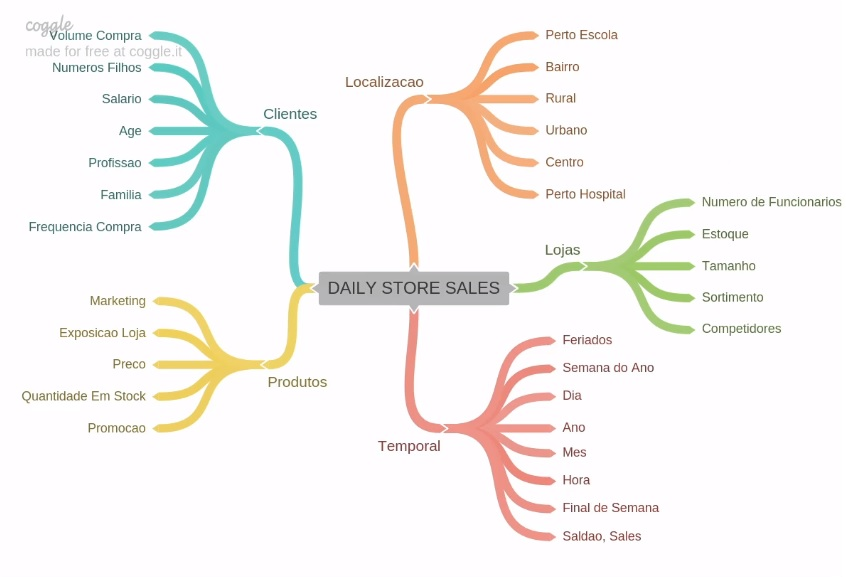

In [18]:
Image('img\MindMapHypothesis.jpg')

## 2.1 Criação de Hipóteses

### 2.1.1 Hipoteses Loja

In [19]:
**1.** Lojas com maior quadro de funcionario deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com menor porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais proximos deveriam vender menos

**6.** Lojas com competidores a mais tempo deveriam vender mais

SyntaxError: invalid syntax (<ipython-input-19-135e2000e1ab>, line 1)

### 2.1.2 Hipoteses Produto

In [ ]:
**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposicao de produtos deveriam vender mais.

**3.** Lojas com produtos com preco menor deveriam vender mais

**4.** Lojas com promocoes mais agressivas (maiores descontos) deveriam vender mais

**5.** Lojas com promocoes ativas por mais tempo deveriam vender mais

**6.** Lojas com mais dias de promocao deveriam vender mais

**7.** Lojas com mais promocoes consecutivas deveriam vender mais

### 2.1.3 Hipoteses Tempo

In [ ]:
**1.** Lojas abertas durante o feriado de natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas  deveriam vender mais depois do dia 10 de cada meses

**5.** Lojas  deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.2 Lista Final de Hipoteses 

In [ ]:
**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos

**3.** Lojas com competidores a mais tempo deveriam vender mais

In [ ]:
**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promocao deveriam vender mais

**6.** Lojas com mais promocoes consecutivas deveriam vender mais

In [ ]:
**7.** Lojas abertas durante o feriado de natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas  deveriam vender mais depois do dia 10 de cada meses

**11.** Lojas  deveriam vender menos aos finais de semana

**12.** Lojas deveriam vender menos durante os feriados escolares

## 2.3 Feature Engineering

In [14]:
import datetime

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1 )
df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days).astype( 'int64' )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] )/7).apply(lambda x: x.days).astype( 'int64' )


# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


<ipython-input-14-a442b0a7ff80>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [77]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [15]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [16]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das colunas

In [80]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [17]:
cols_drop = ['open', 'customers', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1)

In [82]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,extended,extended,extended,extended,extended
competition_distance,1270.0,570.0,14130.0,620.0,29910.0


# 4.0 PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)

In [18]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

C:\Users\maryy\Anaconda3\envs\DataScience_Em_Producao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

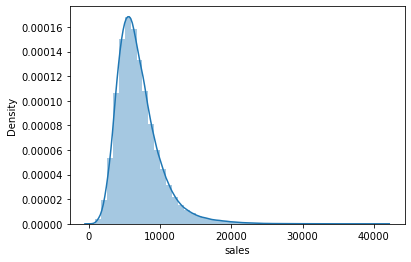

In [85]:
sns.distplot(df4['sales'])

### 4.1.2 Numberical Variable

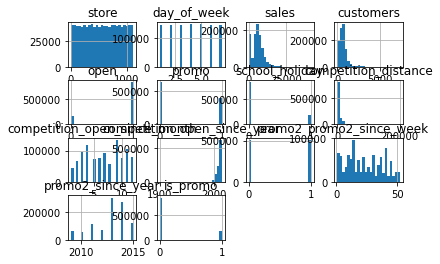

In [86]:
num_attributes.hist( bins=25 );

### 4.1.3 Categorical Variable

In [87]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

C:\Users\maryy\Anaconda3\envs\DataScience_Em_Producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: min() arg is an empty sequence

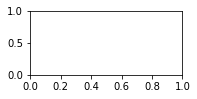

In [88]:
# State Holiday

plt.subplot( 3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True, )
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='public_holiday', shade=True, )
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='public_holiday', shade=True, )


# Store Type

plt.subplot( 3, 2, 3)
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True, )
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True, )
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True, )
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True, )

# Assortment

plt.subplot( 3, 2, 5)
sns.countplot( a['assortment'] )

plt.subplot( 3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True, )
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True, )
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True, )



## 4.2 Análise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS

In [ ]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### **H2.** Lojas com competidores mais proximos deveriam vender menos
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MENOS.

In [ ]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure( figsize=(25,15))

plt.subplot( 1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot( 1, 3, 2)
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks( rotation=90)

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True)


### **H3.** Lojas com competidores a mais tempo deveriam vender mais
**FALSA** Lojas com COMPETIDORES HÁ MAIS TEMPO vendem MENOS.

In [ ]:
plt.figure( figsize=(20, 10))

plt.subplot( 1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot( x='competition_time_month', y='sales', data=aux2);
plt.xticks( rotation=90);

plt.subplot( 1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);

### **H4.** Lojas com promocoes ativas por mais tempo deveriam vender mais
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos depois de um certo periodo de promocao

In [ ]:
aux1 = df4[['promo_time_week', 'sales']].groupby('sales').sum().reset_index()

plt.figure(figsize=(50,30))

plt.subplot(2, 2, 1)
aux2 = aux1[aux1['promo_time_week'] > 0 ] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(2, 2, 2)
sns.regplot( x='promo_time_week', y='sales', data=aux2)


plt.subplot(2, 2, 3)
aux3 = aux1[aux1['promo_time_week'] < 0 ] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90);

plt.subplot(2, 2, 4)
sns.regplot( x='promo_time_week', y='sales', data=aux3)












### <s>**H5.** Lojas com mais dias de promocao deveriam vender mais</s>

### **H6.** Lojas com mais promocoes consecutivas deveriam vender mais
**FALSA** Lojas com promocoes consecutivas vendem menos

In [ ]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2']).sum().reset_index()

In [ ]:


aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()



aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax )


ax.legend(labels=['Tradicional e Extendida', 'Extendida']);

### **H7.** Lojas abertas durante o feriado de natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado de natal vendem menos

In [ ]:
plt.figure( figsize=( 20, 10))
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot (1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1);

plt.subplot (1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday']).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2);


###  **H8.** Lojas deveriam vender mais ao longo dos anos
**FALSA** Lojas vendem menos ao longo dos anos

In [ ]:
plt.figure( figsize=(20, 10))

aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot( 1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


###  **H9.** Lojas deveriam vender mais no segundo semestre do ano
**FALSA** Lojas vendem menos no segundo semestre do ano

In [ ]:
plt.figure( figsize=(20, 10))

aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot( 1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


###  **H10.** Lojas  deveriam vender mais depois do dia 10 de cada meses
**TRUE** Lojas vendem mais depois do dia 10 de cada mes

In [ ]:
plt.figure( figsize=(20, 10))

aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot( 2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot( 2, 2, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot( 2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2)

### **H11.** Lojas  deveriam vender menos aos finais de semana
**TRUE** Lojas vendem menos aos finais de semana

In [ ]:
plt.figure( figsize=(20, 10))

aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot( 1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H12.** Lojas deveriam vender menos durante os feriados escolares
**VERDADEIR** Lojas vendem menos durante os feriados escolares, exceto nos meses de julho e agosto

In [ ]:
plt.figure( figsize=( 30, 15))

plt.subplot( 2, 1, 1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot( 2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)

## 4.3 Análise Multivariada

## 4.3.1 Numerical Attributes

In [ ]:
plt.figure( figsize=(20,10) )

correlation = num_attributes.corr( method='pearson')
sns.heatmap( correlation, annot=True)

## 4.3.2 Categorial Attributes

<AxesSubplot:>

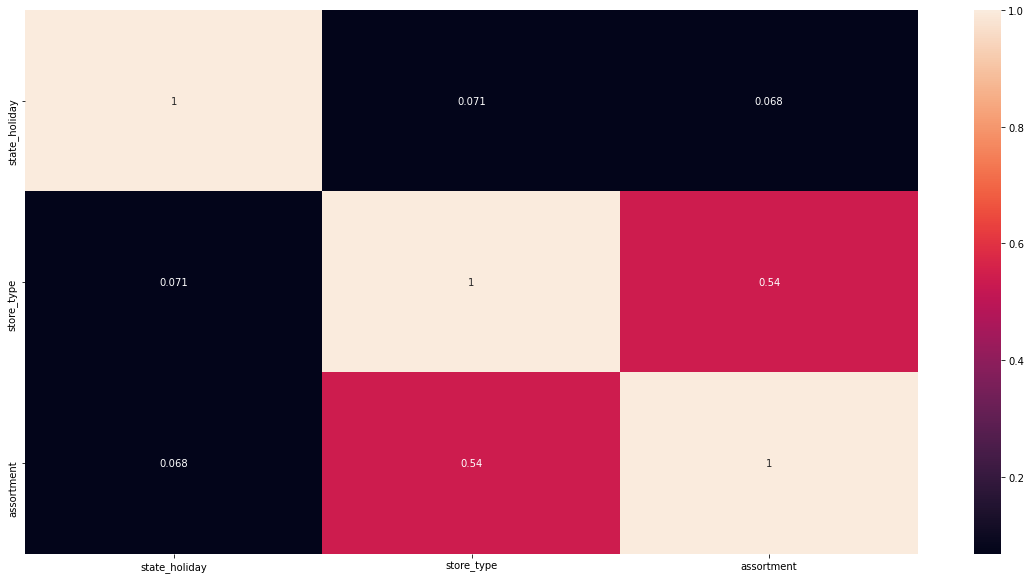

In [19]:
# Only categorical data

a = df4.select_dtypes( include= 'object')

# Calculate Cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )

# Heatmap
plt.figure( figsize=(20, 10))

sns.heatmap( d, annot=True)

# 5.0 PASSO 05 - DATA PREPARATION

In [64]:
df5 = df4.copy()

## 5.1 Normalizacao

## 5.2 Rescaling

In [65]:
a = df5.select_dtypes( include=['float64', 'int64'])

In [66]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )

# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )



## 5.3 Transformation

### 5.3.1 Enconding

In [24]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,...,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,...,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,...,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,...,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,...,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [67]:
# state_holiday - One hot enconding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

### 5.3.2 Response Variable Transformation

In [68]:
df5['sales'] = np.log1p( df5['sales'])

C:\Users\maryy\Anaconda3\envs\DataScience_Em_Producao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

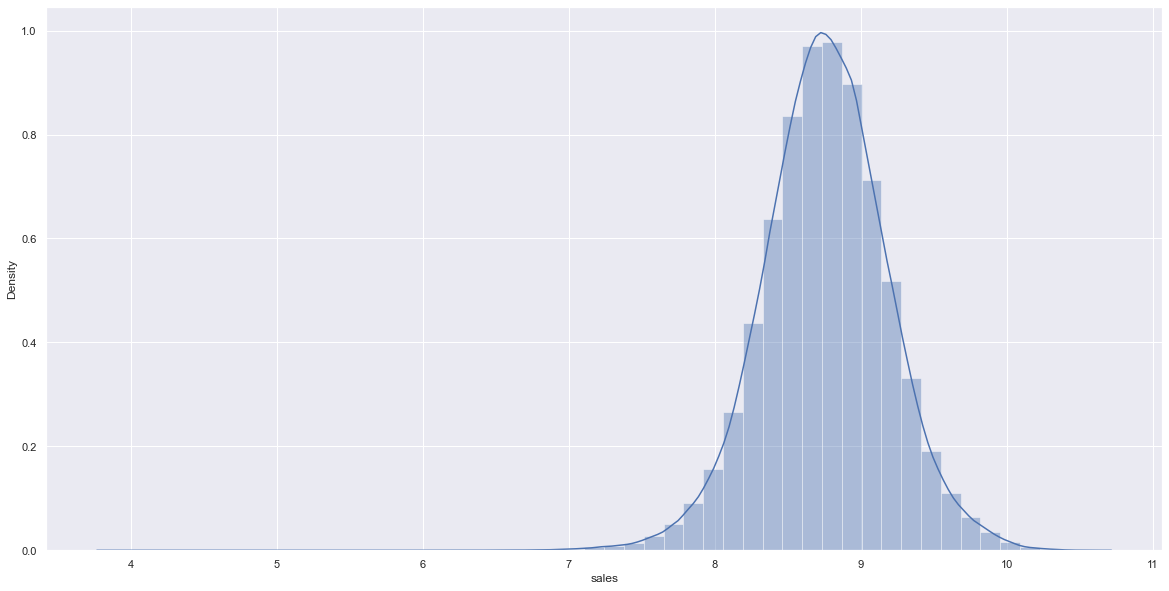

In [61]:
plt.figure(figsize=(20,10))
sns.distplot( df5['sales'] )

### 5.3.3 Nature Transformation

In [69]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2. * np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2. * np.pi/7) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2. * np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2. * np.pi/52) ) )

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2. * np.pi/12) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2. * np.pi/12) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2. * np.pi/30) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2. * np.pi/30) ) )

# 6.0 PASSO 06 - FEATURE SELECTION

In [70]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [73]:
cols_drop = ['week_of_year', 'month', 'day', 'day_of_week', 'promo_since', 'competition_since', 'year_week']

df6 = df6.drop( cols_drop, axis=1)

In [78]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days= 7*6)

Timestamp('2015-06-19 00:00:00')

In [80]:
# Training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [93]:
# Training and Test dataset for boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1 ).values
y_train_n = y_train.ravel()

# Define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1)

# Define boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1 Best features from boruta

In [95]:
cols_selected = boruta.support_.tolist()

# Best Features
X_train_fs = X_train.drop( ['date', 'sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta 
cols_not_selected_boruta = list( np.setdiff1d(X_train_fs.columns, cols_selected_boruta) )

In [96]:
cols_selected_boruta = 

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'week_of_year_cos',
 'month_cos',
 'day_sin',
 'day_cos']

# 6.3 Manual Feature Selection